In [1]:
from ModelsContainer import ModelsContainer
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical
from sklearn.metrics import roc_auc_score
import toploader
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os

from utils.plot_utils import newplot, stamp, add_whitespace

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))


2023-09-06 15:25:21.303404: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-06 15:25:21.304700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 15:25:21.329067: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-06 15:25:21.329562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 15:25:21.744293: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

Num GPUs Available:  0
GPUs Available:  []


In [2]:

# Parameters
train = 250000
val = 10000
test = 10000
k_order = 2
run_name = "angularities"
dataset = "qg"

# k_order = int(sys.argv[1]) 
# run_name = sys.argv[3]
# dataset = sys.argv[2] # either "qg" or "top"


epochs = 100
batch_size=512
callbacks =None
verbose = 2


num_models_to_train = 3 ##number of models to use to make error bars
input_dim = 2
output_dim = 1


# Directory Handling
base_dir = "Data"
run_dir = os.path.join(base_dir, run_name)
run_dir = os.path.join(run_dir, f"order_{k_order}")
model_dir = os.path.join(run_dir, "Models")
if not os.path.exists(run_dir):
    os.makedirs(run_dir)
    os.makedirs(model_dir, exist_ok=True)
topdir = "/n/holyscratch01/iaifi_lab/rikab/top"


In [3]:
if dataset == "qg":
    X, Y = qg_jets.load(train+val+test)
    X = X[:,:,:3].astype(np.float32)
    for x in X:
        mask = x[:,0] > 0
        yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
        x[mask,1:3] -= yphi_avg
        x[mask,0] /= x[:,0].sum()


    Y = to_categorical(Y, num_classes=2)

    (z_train, z_val, z_test,
    p_train, p_val, p_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

    X_train = [z_train, p_train]
    X_val = [z_val, p_val]
    X_test = [z_test, p_test]

elif dataset == "top":
    X_train, Y_train = toploader.load(cache_dir=topdir, dataset="train", num_data = train)
    X_test, Y_test = toploader.load(cache_dir=topdir, dataset="test", num_data=test)
    X_val, Y_val = toploader.load(cache_dir=topdir, dataset="val", num_data=test)

    def format(X):

        for x in X:
            mask = x[:,0] > 0
            yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
            x[mask,1:3] -= yphi_avg
            x[mask,0] /= x[:,0].sum()

        return [X[:,:,0], X[:,:,1:3]]
    
    X_train = format(X_train)
    X_test = format(X_test)
    X_val = format(X_val)

    Y_train = to_categorical(Y_train, num_classes=2)
    Y_test = to_categorical(Y_test, num_classes=2)
    Y_val = to_categorical(Y_val, num_classes=2)


else:
    raise ValueError("dataset must be either `top` or `qg`!")


print("Data loaded!")

Data loaded!


In [4]:
def compute_angularities(events, beta = 2.0):

    y = []
    for x in events:
        zs = x[:,0]
        thetas = np.sqrt(np.sum(x[:,1:3] **2, axis = 1))
        y.append(np.sum(zs * np.power(thetas, beta)))

    return np.array(y)

In [5]:
from energyflow.archs.moment import EFN_moment, PFN_moment

k_order = 2
model = EFN_moment(**{'Phi_mapping_dim' : [input_dim,2],
                            'output_dim' : 1, 'output_act' : 'linear',
                            'Phi_sizes' : [2,], 'Phi_acts' : 'linear', "Phi_l1_regs" :  0,
                            'F_sizes' : [1,], 'F_acts': 'linear', "F_l1_regs" :  0,
                            'order' : k_order , 'architecture_type':'moment',
                            'loss': 'mse','metrics': 'mse'})
print()
print()

angularities = compute_angularities(X, beta = 2.0)
(z_train, z_val, z_test,
    p_train, p_val, p_test,
    Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], angularities, val=val, test=test)

X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2)]    0           []                               
                                                                                                  
 tdist0_0 (TimeDistributed)     (None, None, 2)      6           ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, None, 2)      0           ['tdist0_0[0][0]']               
                                                                                                  
 tdist0_1 (TimeDistributed)     (None, None, 2)      6           ['activation[0][0]']             
                                                                                              

In [6]:
model_name = f"O{k_order}_L{2}_linear"

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
# history = model.fit(X_train, Y_train,
#                     epochs = epochs, batch_size = batch_size,
#                     validation_data = (X_val, Y_val),
#                     callbacks=[callback], verbose=verbose,)

# model.save_weights(os.path.join(model_dir , model_name+ f"_{sample}.keras"))


313/313 [==============================] - 0s 859us/step - loss: 0.0739 - mse: 0.0739
0.07394726574420929


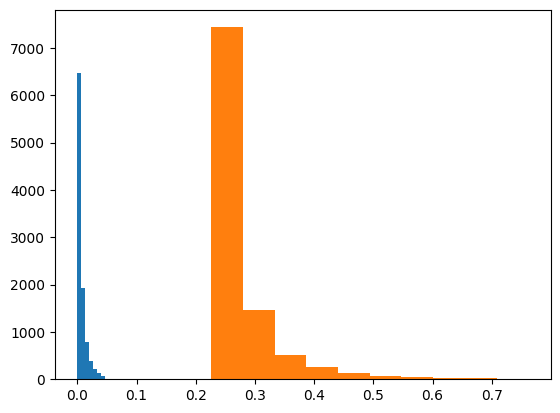

In [7]:
plt.hist(Y_test)
plt.hist(model.predict(X_test))

print(model.evaluate(X_test, Y_test)[0])

# $\beta$ Scan

In [8]:
# # k_order = 4
# for k_order in [1, 2, 3, 4]:
#     print()
#     losses = []
#     for beta in np.linspace(0, 4, 25):
#         model = EFN_moment(**{'Phi_mapping_dim' : [input_dim,2],
#                                     'output_dim' : 1, 'output_act' : 'linear',
#                                     'Phi_sizes' : [], 'Phi_acts' : 'linear', "Phi_l1_regs" :  0,
#                                     'F_sizes' : [], 'F_acts': 'linear', "F_l1_regs" :  0,
#                                     'order' : k_order , 'architecture_type':'moment',
#                                     'loss': 'mse','metrics': 'mse'}, summary = False, bias = False)

#         angularities = compute_angularities(X, beta)
#         (z_train, z_val, z_test,
#             p_train, p_val, p_test,
#             Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], angularities, val=val, test=test)

#         X_train = [z_train, p_train]
#         X_val = [z_val, p_val]
#         X_test = [z_test, p_test]

#         callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)
#         history = model.fit(X_train, Y_train,
#                             epochs = epochs, batch_size = batch_size,
#                             validation_data = (X_val, Y_val),
#                             callbacks=[callback], verbose=0,)
        
#         print(k_order, beta, model.evaluate(X_test, Y_test, verbose = 0)[1])
#         losses.append(model.evaluate(X_test, Y_test, verbose = 0)[1])
#     np.save(f"Data/angularities/O{k_order}_losses_reg_3.npy", np.array(losses))

log


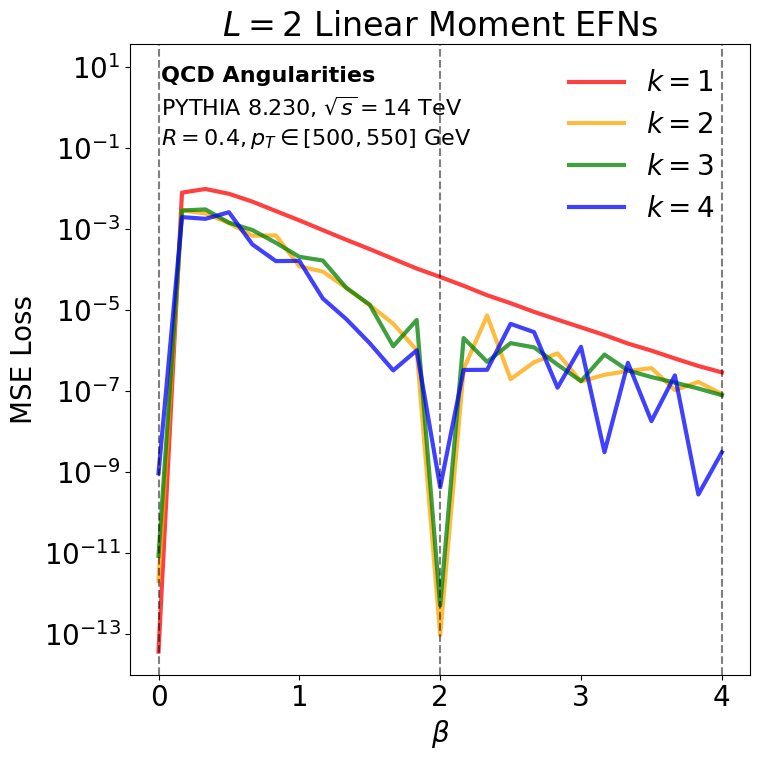

In [10]:
fig, ax = newplot()



def mean_and_std(i):

    means = []
    stds = []

    scores = []

    start = 0 if i != 4 else 1
    for run in range(start, 3):
        scores.append(np.load(f"Data/angularities/O{i}_losses_reg_{run}.npy"))

    scores = np.log(np.vstack(scores))

    return np.exp(np.mean(scores, axis = 0)), np.exp(np.std(scores, axis = 0))




losses_1 = np.load("Data/angularities/O1_losses_reg_0.npy") /3
losses_2 = np.load("Data/angularities/O2_losses_reg_0.npy") /3
losses_3 = np.load("Data/angularities/O3_losses_reg_0.npy") /3
losses_4 = np.load("Data/angularities/O4_losses_reg_0.npy") /3 * 0

for i in range(1,3):
    losses_1 += np.load(f"Data/angularities/O1_losses_reg_{i}.npy") /3
    losses_2 += np.load(f"Data/angularities/O2_losses_reg_{i}.npy") /3
    losses_3 += np.load(f"Data/angularities/O3_losses_reg_{i}.npy") /3
    losses_4 += np.load(f"Data/angularities/O4_losses_reg_{i}.npy") /2


    

beta = np.linspace(0, 4, 25)
colors = ["red", "orange", "green", "blue"]
for (i,k) in enumerate([1, 2, 3, 4]):

    means, std = mean_and_std(k)
    plt.plot(beta, means, color = colors[i], lw = 3, label = f"$k = {k}$  ", alpha = 0.75)
    # plt.plot(beta, losses_1, color = "red", label = r"$k = 1$", lw = 3)
    # plt.plot(beta, losses_2, color = "yellow", label = r"$k = 2$", lw = 3)
    # plt.plot(beta, losses_3, color = "green", label = r"$k = 3$", lw = 3)
    # plt.plot(beta, losses_4, color = "blue", label = r"$k = 4$", lw = 3)

plt.axvline(0, color = "black", alpha = 0.5, ls = "--")
plt.axvline(2, color = "black", alpha = 0.5, ls = "--")
plt.axvline(4, color = "black", alpha = 0.5, ls = "--")

plt.yscale("log")


# Stamp
add_whitespace(ax, upper_fraction=4)
line_0 = "QCD Angularities"
line_1 = "PYTHIA 8.230, $\sqrt{s} = 14$ TeV"
line_2 = "$R = 0.4, p_T \in [500, 550]$ GeV"
stamp(0.05, 0.95, line_0 = line_0, line_1 = line_1, line_2 = line_2)

plt.xlabel(r"$\beta$")
plt.ylabel("MSE Loss")
plt.title(r"$L = 2$ Linear Moment EFNs")
plt.legend(frameon = False, loc = "upper right")
plt.savefig("Plots/beta_plot.pdf")